# Image Features and Alignment

## Importing Modules

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

## Downloading Assets

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists. 
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path) 

## Read Template and Scanned Image

In [4]:
# reference image
ref_filename = "form.jpg"
print("Reference Image: ", ref_filename)
img1 = cv2.imread(ref_filename, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

# scanned image
img_filename = "scanned-form.jpg"
print("Scanned Image: ", img_filename)
img2 = cv2.imread(img_filename, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

Reference Image:  form.jpg
Scanned Image:  scanned-form.jpg


### <font color="green">Display Template and Scanned Image</font>

Text(0.5, 1.0, 'Scanned Form')

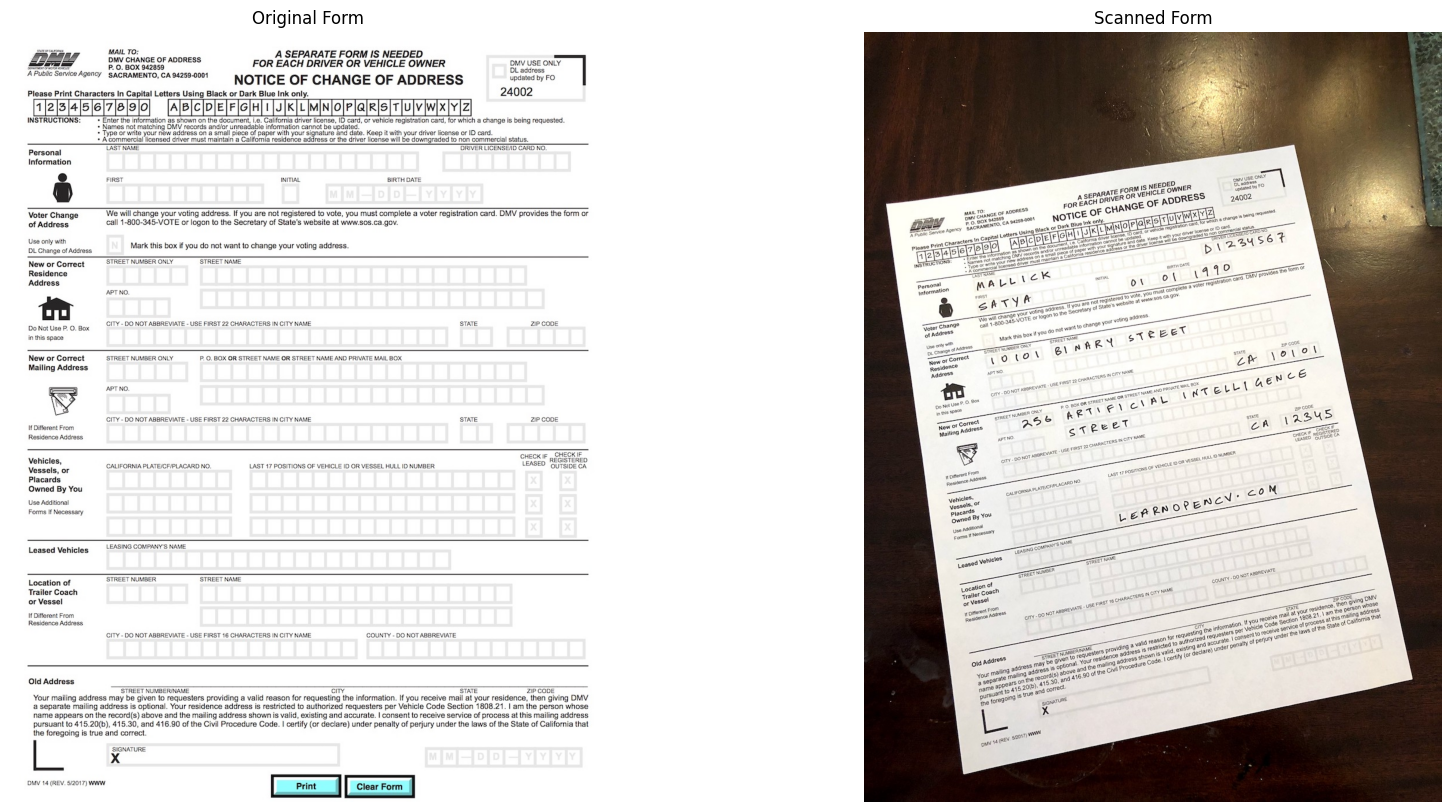

In [17]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1); plt.axis('off'); plt.imshow(img1); plt.title("Original Form")
plt.subplot(1, 2, 2); plt.axis('off'); plt.imshow(img2); plt.title("Scanned Form")

## Find keypoints in Images

In [18]:
# Convert images to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# Display keypoints on the images
img1_kp = cv2.drawKeypoints(img1, keypoints1, outImage=np.array([]), color=(255, 0, 0), 
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img2_kp = cv2.drawKeypoints(img2, keypoints2, outImage=np.array([]), color=(255, 0, 0),
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

Text(0.5, 1.0, 'Scanned Form')

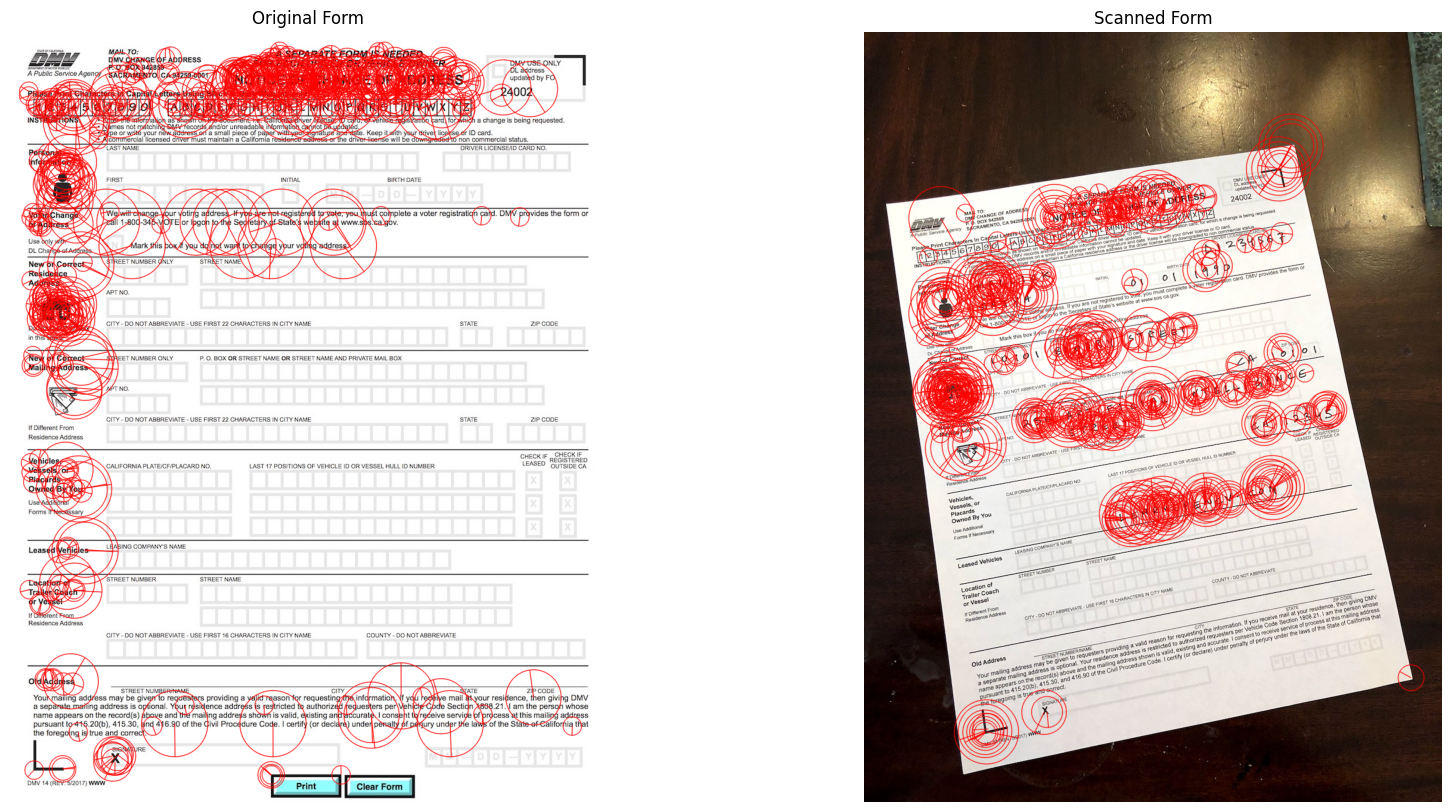

In [19]:
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1); plt.axis('off'); plt.imshow(img1_kp); plt.title("Original Form")
plt.subplot(1, 2, 2); plt.axis('off'); plt.imshow(img2_kp); plt.title("Scanned Form")

## Matching Keypoints

In [20]:
# Match features
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
num_good_matches = int(len(matches) * 0.1)
matches = matches[:num_good_matches]

Text(0.5, 1.0, 'Originam Form')

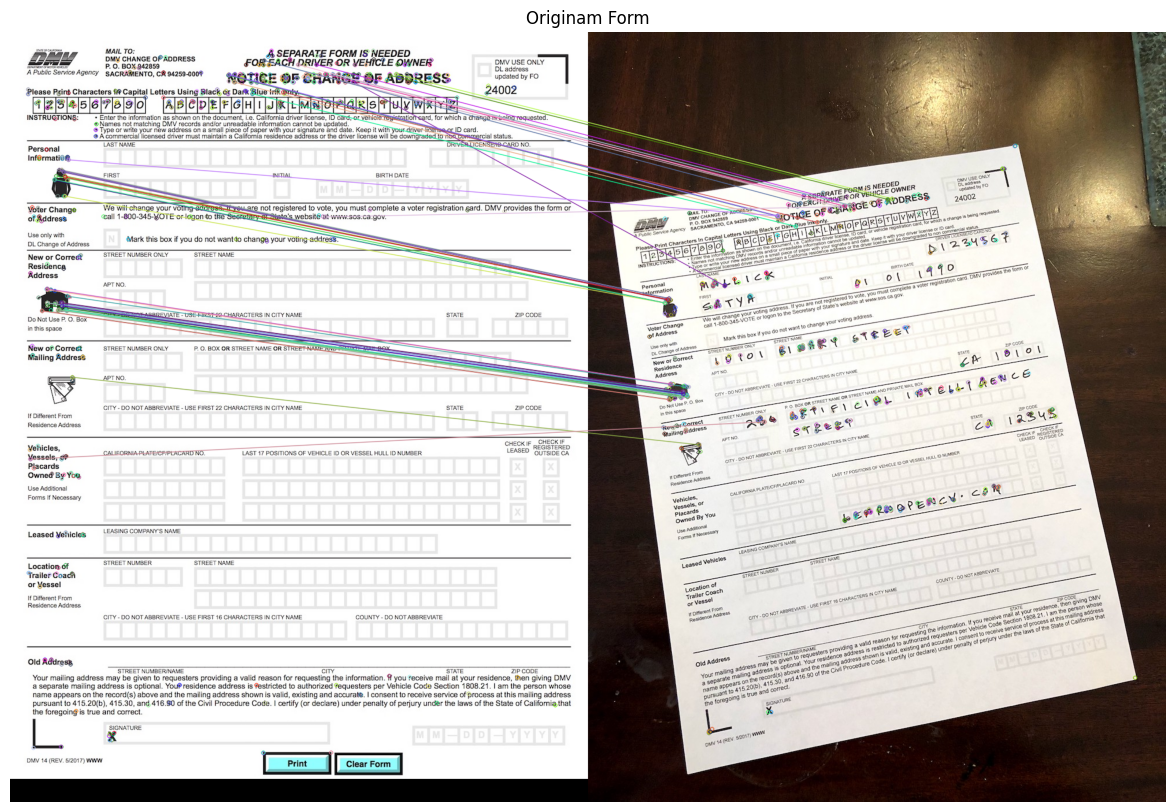

In [21]:
# Draw top matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(img_matches); plt.axis('off'); plt.title("Originam Form")

## Find Homography

In [22]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Apply Homography

Text(0.5, 1.0, 'Registered Scanned Form')

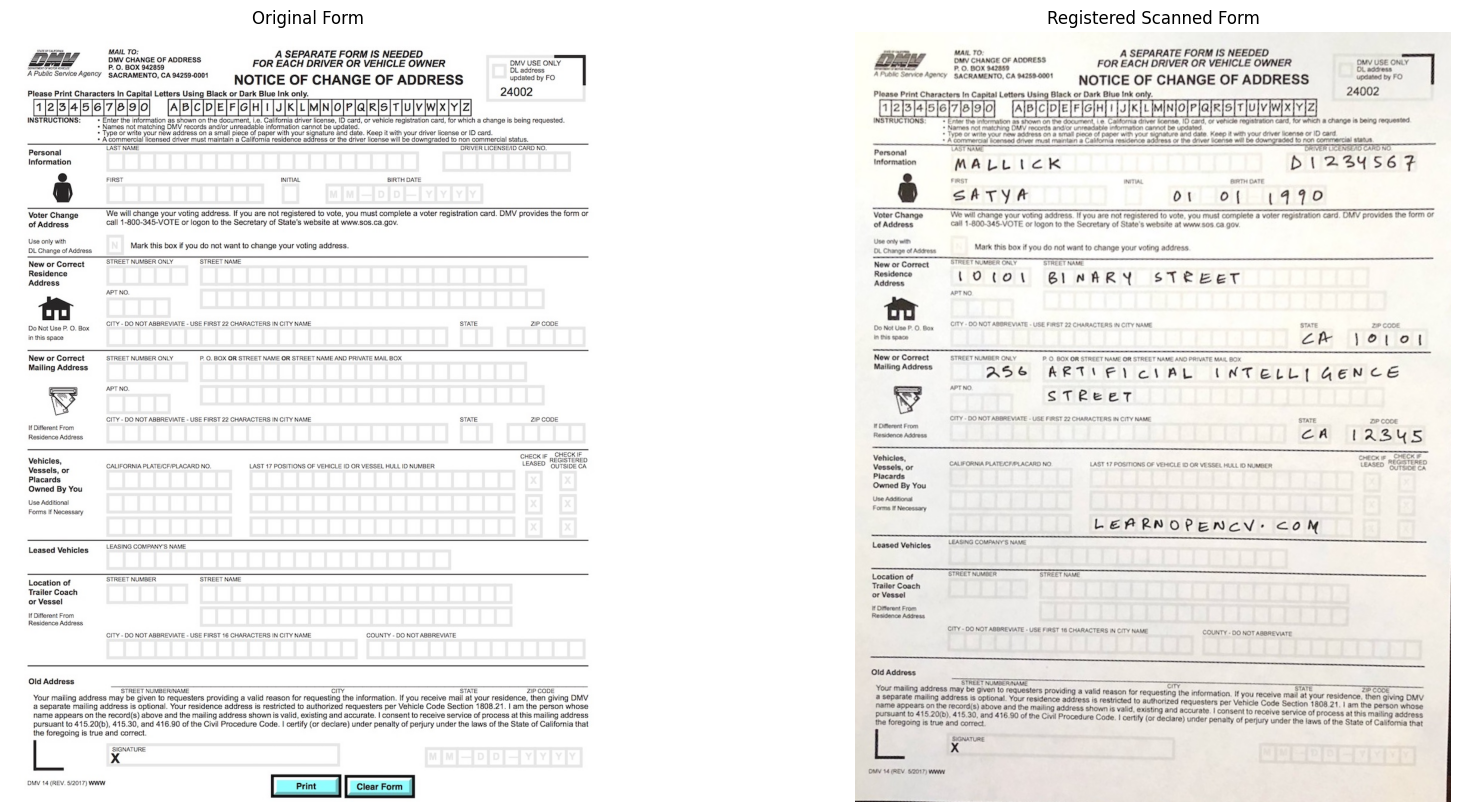

In [24]:
# Use homography to warp image
height, width, channels = img1.shape
img2_reg = cv2.warpPerspective(img2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(1, 2, 1); plt.axis('off'); plt.imshow(img1); plt.title("Original Form")
plt.subplot(1, 2, 2); plt.axis('off'); plt.imshow(img2_reg); plt.title("Registered Scanned Form")